<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1> PCA for Large Datasets </h1> 


<p>In this lab, you will calculate the covariance matrix for datasets with a large number of samples; then, you will use PCA to transform the datase.</p>

<h2>1- Preparation</h2>

Download eigenvectors and eigenvalues:

In [1]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/eigenvectors.pt
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/eigenvalues.pt

--2023-10-10 17:20:46--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/eigenvectors.pt
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262493 (256K) [application/octet-stream]
Saving to: ‘eigenvectors.pt’

eigenvectors.pt     100%[===================>] 256.34K   507KB/s    in 0.5s    

2023-10-10 17:20:48 (507 KB/s) - ‘eigenvectors.pt’ saved [262493/262493]

--2023-10-10 17:20:48--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/eigenvalues.pt
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objec

In [2]:
!pip install Pillow==6.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 8.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [185 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-310
      creating build/lib.linux-x86_64-cpython-310/PIL
      copying src/PIL/__main__.py -> build/lib.linux-x86_64-cpython-310/PIL
      copying src/PIL/ImageDraw2.py -> build/lib.linux-x86_64-cpython-310/PIL
      copying src/PIL/ImageMode.py -> build/lib.linux-x86_64-cpython-310/PIL
      copying src/PIL/PaletteFile.py -> build/lib.linux-x86_64-cpython-310/PIL
      copying src/PIL/DdsImagePlugin.py -> build/lib.linux-x86_64-cpython-310/PIL
      copying src/PIL/PixarImagePlugin.py -> build/lib.linux-x86_64-cpython-310/PIL
      copying src/PIL/ImageChops.py -> build/lib.linux-

Failed to build Pillow
ERROR: Could not build wheels for Pillow, which is required to install pyproject.toml-based projects


We'll need the following libraries:

In [3]:
# Import the libraries we need for this lab
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

Use the following function to visualize data: 

In [12]:
# Display data

def show_data(data_sample,y,raw_image=True):
    if raw_image:
        plt.imshow(data_sample[0].numpy().reshape(16, 16), cmap='gray')
    else:
        plt.imshow(data_sample[0].numpy().reshape(16, 16))
    plt.title('y = ' + str(y)) # removed .item()

 PCA transform class:

In [5]:
class transform(object):
    def __init__(self, eigenvalues,eigenvectors):
        self.eigenvalues=eigenvalues
        self.eigenvectors=eigenvectors
        #calculate the diagonal matrix of eigenvalues
        dim=eigenvalues[:,0].shape[0]
        diag=torch.eye(dim)
        dim=eigenvalues[:,0].shape[0]
        self.diag=torch.eye(dim)
        
        for n,eigenvalue in enumerate(eigenvalues[:,0]):
            self.diag[n,n]=(eigenvalue+0.01)**(0.5)
            
        
        self.Qin=torch.inverse(diag)
    def PCA(self,X):
        X_hat=torch.mm(X[0].view(1,-1),self.eigenvectors)
        return X_hat


The image is a rectangular  tensor:

In [6]:
IMAGE_SIZE = 16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

<!--Empty Space for separating topics-->

<h2 id="Makeup_Data">2- Load Data</h2> 

Load the training dataset by setting the parameters <code>train</code> to <code>True</code> and convert it to a tensor by placing a transform object in the argument <code>transform</code>.

In [7]:
# Create and print the training dataset
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed )
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

100%|██████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 5850583.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 6468505.04it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 5611280.02it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 28433625.03it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Images are rectangular tensors:

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.32_image_values.png" width="550" alt="MNIST elements" />

We can convert the tensor to a 1D tensor of vector and perform PCA or ZCA.

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter3/3.3.2image_to_vector.gif" width="550" alt="Flattern Image" />

In this cell will calculate the Covariance Matrix and save it. We do it in a way that we don't need to store all the samples in memory. This takes some time so you can load the results in the next cell.

dim=train_dataset[0][0].shape[1]*train_dataset[0][0].shape[2]

mean=torch.zeros((1,dim))
C=torch.zeros((dim,dim))
N_samples=len(train_dataset)
for n in range(N_samples):
    mean=mean+train_dataset[0][0].view(-1,1)
    
mean=mean/N_samples

for n in range(N_samples):
    x=train_dataset[0][0].view(1,-1)
    x=x-mean
    
    C+=torch.mm(torch.t(x),x)
    
C=C/N_samples

eigenvalues,eigenvectors=torch.eig(C,True)
torch.save(eigenvalues, 'eigenvalues.pt') 
torch.save(eigenvectors, 'eigenvectors.pt')

Load eigenvalues and eigenvectors.

In [8]:
eigenvalues=torch.load('eigenvalues.pt')
eigenvectors=torch.load('eigenvectors.pt')

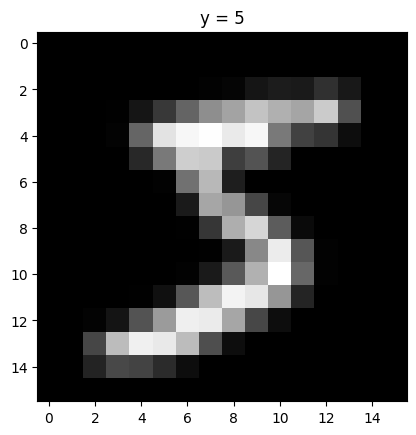

In [13]:
show_data(train_dataset[0][0],train_dataset[0][1])

PCA transform object

In [14]:
transform=transform(eigenvalues,eigenvectors)

We can calculate the PCA transform of the image. We can see the transform for each digit looks similar.   Try changing the variable <code>select_number</code> to change the number.

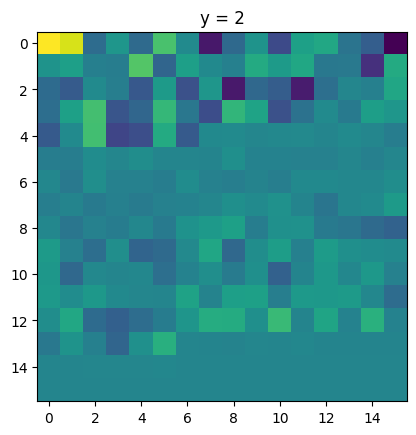

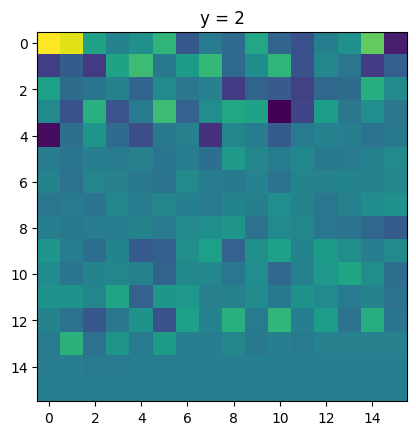

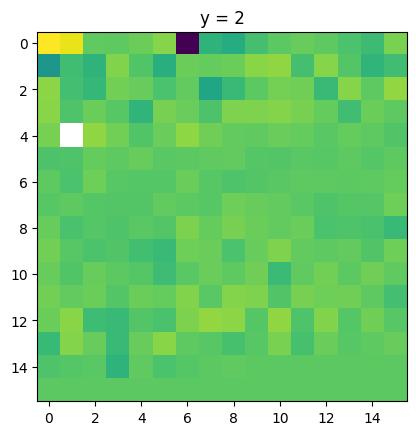

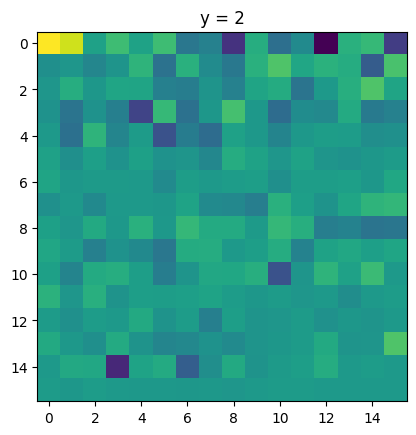

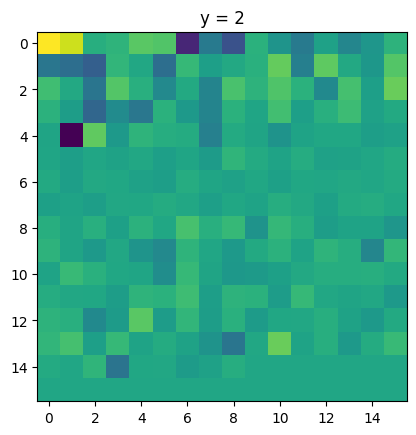

In [17]:
j=0
#select_number from 0 -9
select_number= 2
for i,(X,y) in enumerate(train_dataset):
    if y==select_number:# removed .item()
        j+=1
        Xhat=transform.PCA(X)
        show_data(torch.log(Xhat+1),y=y,raw_image=False)
        plt.show()
    if j==5:
        break


<!--Empty Space for separating topics-->

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

<b>References</b>

<i>K. K. Pal and K. S. Sudeep, “Preprocessing for image classification by convolutional neural networks,” in 2016 IEEE International Conference on Recent Trends in Electronics, Information Communication Technology (RTEICT), 2016, pp. 1778–1781.</i>

Copyright &copy; 2020 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.